In [1]:
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan
import numpy as np
from mechanism_solver import MechanismAStarSolver, MechanismDynamicSolver
from approval_profile import *
from mechanism import *
import copy
import numba


In [2]:
def axiom(projects, ballots, labels, costs, budget):
    n_clusters = max(labels) + 1
    clusters = [ballots[labels == i] for i in range(n_clusters)]
    b = [] 
    r = []
    for cluster in clusters:
        b.append(np.sum(np.mean(cluster,0)[projects]*costs[projects])/budget)
        r.append(len(cluster)/len(ballots))
    b = np.array(b)
    b /= sum(b)
    s = 0
    for x,y in zip(b,r):
        s += np.abs(x-y)**2
        print(f"{(x-y):.3f}")
    print(s)


In [101]:
with open("data//sorted_files.pkl", 'rb') as f:
    file_division = pickle.load(f)
    
approval_profile_files = sorted(file_division['approval'], key=lambda x: x[2], reverse=True)
profile = Profile(approval_profile_files[0][0])


In [281]:
profile = Profile_Synthetic(list(range(4000, 1, -200)), list(range(1000, 1, -50)), budget_distribution=uniform, low=500, high=10000, spread_of_approvals=2.5, sdcavpd=0.3, noise=0.02)

In [295]:
# profile = Profile_Synthetic.load('gen_data//55000_20_liniear.pb')
data = profile.ballots.astype(int)
subdata = copy.deepcopy(data)
np.random.shuffle(subdata)
old_clusters = profile.clusters
old_labels = [j for i,cluster in enumerate(old_clusters) for j in len(cluster)*[i]]
# old_labels = [sum(x) for x in data]

In [283]:
np.set_printoptions(threshold=10000)
x,y = np.unique(profile.ballots, return_counts=True, axis=0)
print(len(y), len(profile.ballots))
print(profile.approvals)
z,w = np.unique(np.sum(profile.ballots, 1), return_counts=True)
list(zip(z,w))
# sorted(y, reverse=True)


3575 10500
[3746. 3937. 3942. 2846. 3660. 2347. 3162. 2957. 2907. 2591. 2157. 2282.
 1738. 1469. 1597. 1242.  858.  782.  746.  386.]


[(1.0, 1173),
 (2.0, 1231),
 (3.0, 1900),
 (4.0, 1574),
 (5.0, 1418),
 (6.0, 1333),
 (7.0, 954),
 (8.0, 471),
 (9.0, 326),
 (10.0, 80),
 (11.0, 31),
 (12.0, 7),
 (14.0, 2)]

In [284]:
@numba.njit()
def XOR_dist(a,b):
    XOR = np.logical_xor(a,b).sum()
    OR =  np.logical_or(a,b).sum()
    return (len(a) + XOR - OR) / (len(a) + OR - XOR) 

a = np.array([1,1,1,1,1,0])
b = np.array([0,0,1,1,0,0])
c = np.array([0,1,0,1,0,0])
d = np.array([1,0,1,0,1,1])
XOR_dist(a,b), XOR_dist(b,c), XOR_dist(c,d), XOR_dist(a,d)

(0.5, 0.7142857142857143, 1.0, 0.3333333333333333)

In [285]:
# reducer = umap.UMAP(n_components=2, n_neighbors=100, metric='jaccard')
# reducer = umap.UMAP(n_components=2, n_neighbors=15, metric='manhattan')
reducer = umap.UMAP(n_components=2, n_neighbors=150, metric=XOR_dist)
reducer.fit(subdata[:5000])
print("fit done")
embedding = reducer.transform(data)

C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1495: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


fit done


In [286]:
# n_clusters = len(old_clusters)
# k = GaussianMixture(n_clusters).fit(embedding)
# k.labels_ = k.predict(embedding)

In [287]:
# mechanism = Mechanism(profile)
# projects = mechanism.solve()
# axiom(projects, profile.ballots, k.labels_, profile.costs, profile.budget)

In [288]:
# mechanism = Mechanism(profile)
# projects = mechanism.solve("max_approval")
# axiom(projects, profile.ballots, k.labels_, profile.costs, profile.budget)

In [289]:
# index = 0
# for i,cluster in enumerate(old_clusters):
#     old_cluster_block = k.labels_[index:index+len(cluster)]
#     occurence_count = Counter(old_cluster_block)
#     try:
#         print(occurence_count.most_common(1)[0][0], occurence_count.most_common(2)[1][0])
#         print(np.mean(occurence_count.most_common(1)[0][0] == old_cluster_block))
#         print(np.mean(occurence_count.most_common(2)[1][0] == old_cluster_block))
#     except IndexError:
#         print(occurence_count.most_common(1)[0][0])
#         print(np.mean(occurence_count.most_common(1)[0][0] == old_cluster_block))        
#     index += len(cluster)

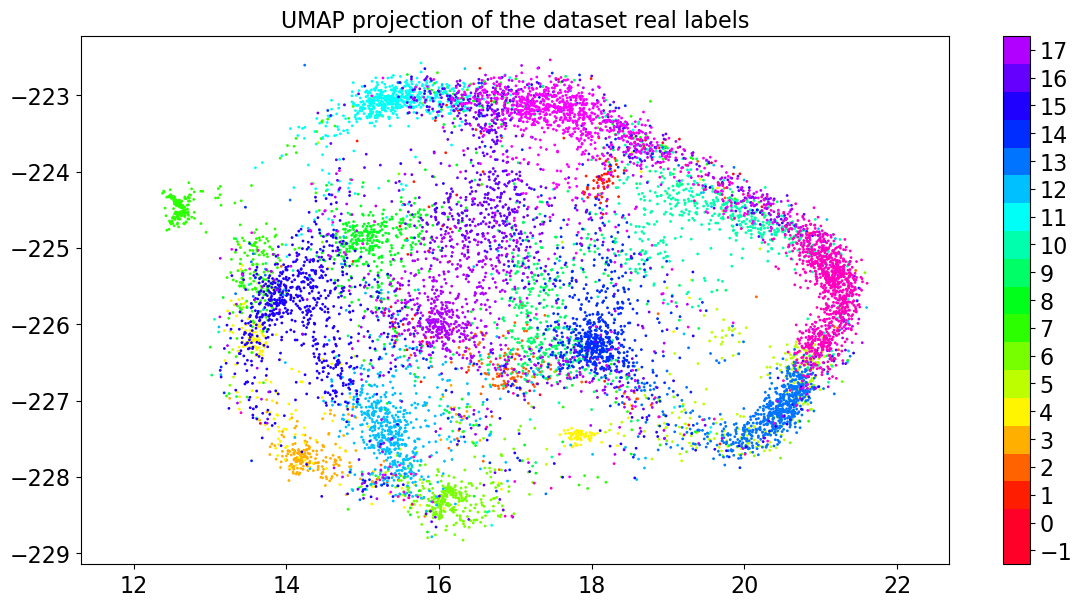

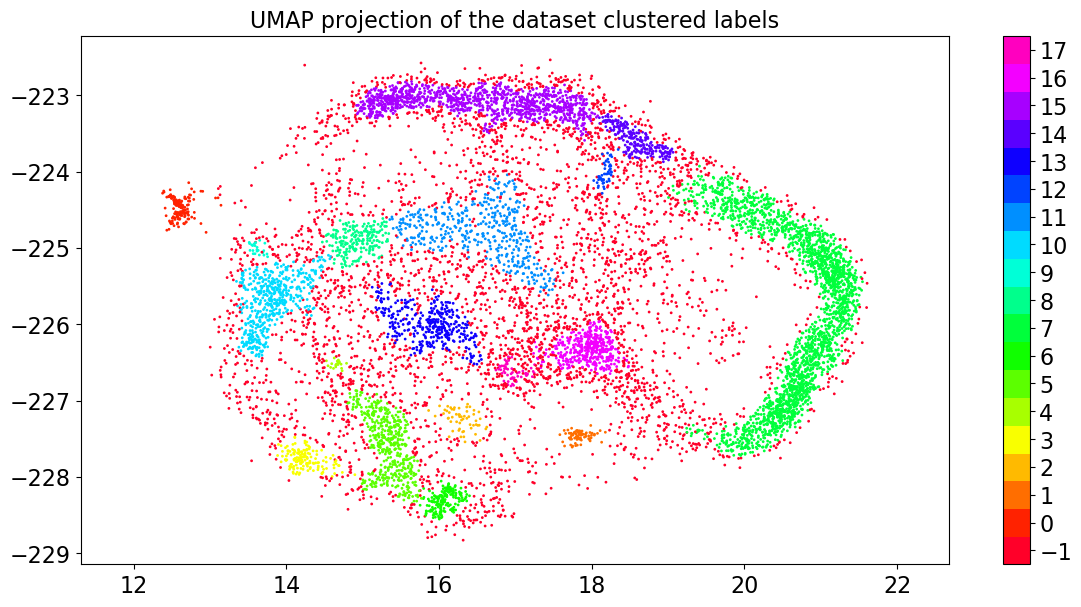

In [296]:
# n_clusters = len(old_clusters)
# k = KMeans(n_clusters).fit(embedding)

# n_clusters = len(old_clusters)
# # n_clusters = 20
# k = GaussianMixture(n_clusters).fit(embedding)
# k.labels_ = k.predict(embedding)

# k = DBSCAN(0.9).fit(embedding)
# n_clusters = max(k.labels_) + 1

k = hdbscan.HDBSCAN(min_cluster_size=len(data)//500, gen_min_span_tree=True).fit(embedding)
n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=old_labels, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset real labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=old_labels, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset real labels', fontsize=16)
    plt.show()

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset clustered labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset clustered labels', fontsize=16)
    plt.show()

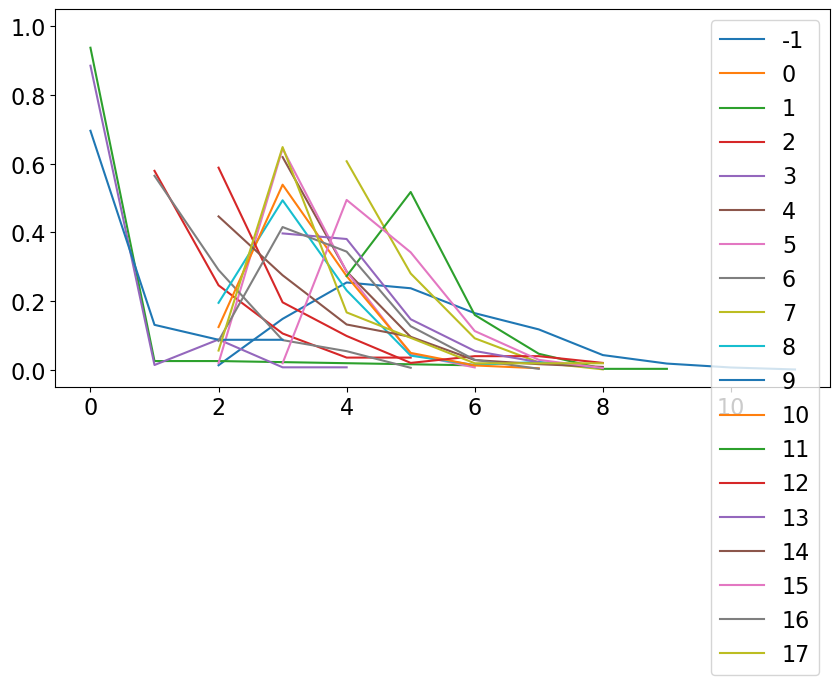

In [293]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

0
{0: 0.9602649006622517, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 1.0, 18: 0.0, 19: 0.0}
151


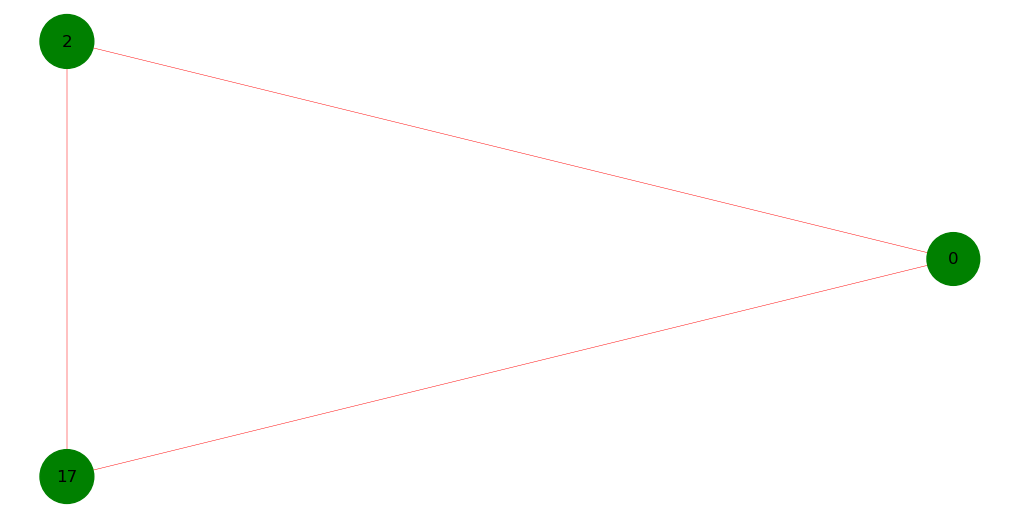

1
{0: 0.9875, 1: 0.9625, 2: 0.0125, 3: 0.0125, 4: 0.0125, 5: 0.0, 6: 0.0, 7: 0.0125, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0125, 13: 0.0125, 14: 0.0125, 15: 0.0, 16: 0.975, 17: 0.0, 18: 0.0, 19: 0.0}
80


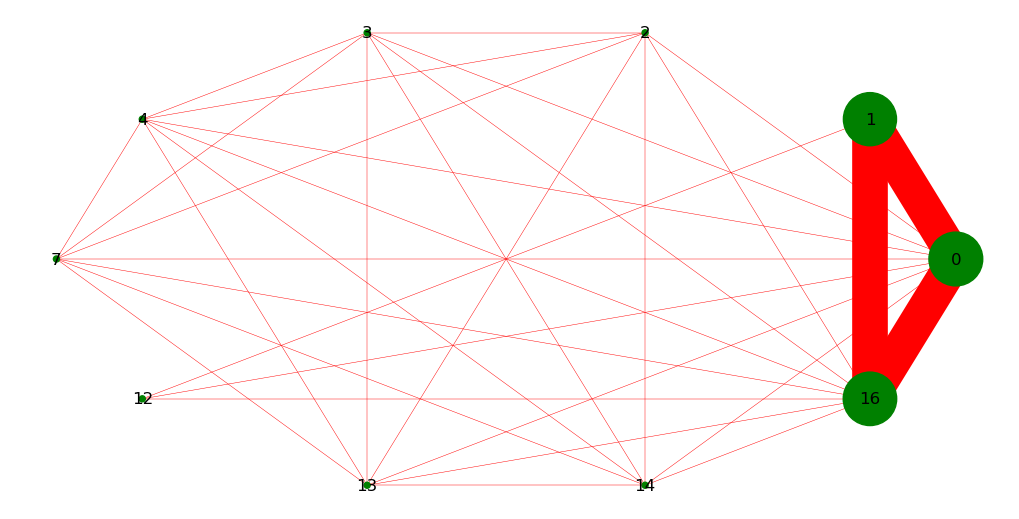

2
{0: 0.3157894736842105, 1: 0.0, 2: 0.15789473684210525, 3: 0.0, 4: 0.19298245614035087, 5: 0.0, 6: 0.8771929824561403, 7: 0.0, 8: 0.05263157894736842, 9: 0.19298245614035087, 10: 0.017543859649122806, 11: 0.03508771929824561, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.10526315789473684, 17: 0.07017543859649122, 18: 0.0, 19: 0.0}
57


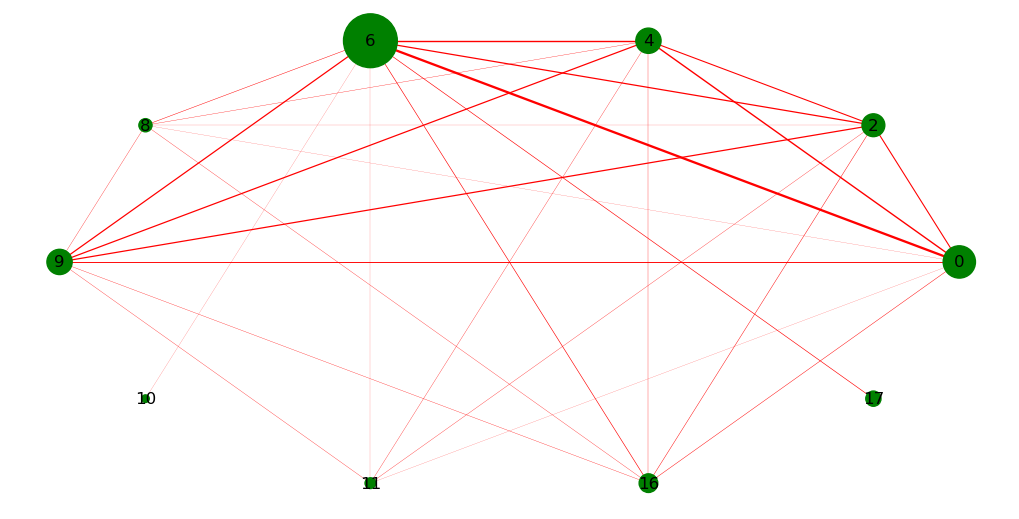

3
{0: 0.10135135135135136, 1: 0.0, 2: 0.006756756756756757, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.8986486486486487, 7: 0.0, 8: 0.0, 9: 0.013513513513513514, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.9864864864864865, 14: 0.0, 15: 0.0, 16: 0.10135135135135136, 17: 0.0, 18: 0.0, 19: 0.0}
148


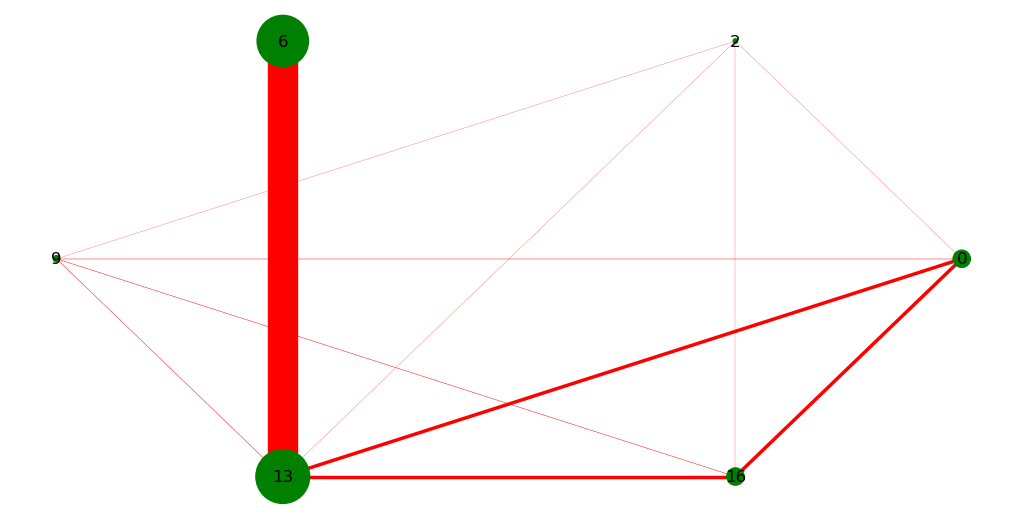

4
{0: 0.8095238095238095, 1: 0.0, 2: 0.2857142857142857, 3: 0.0, 4: 0.7142857142857143, 5: 0.0, 6: 0.23809523809523808, 7: 0.09523809523809523, 8: 0.0, 9: 0.42857142857142855, 10: 0.14285714285714285, 11: 0.14285714285714285, 12: 0.047619047619047616, 13: 0.9047619047619048, 14: 0.7619047619047619, 15: 0.0, 16: 0.14285714285714285, 17: 0.0, 18: 0.23809523809523808, 19: 0.0}
21


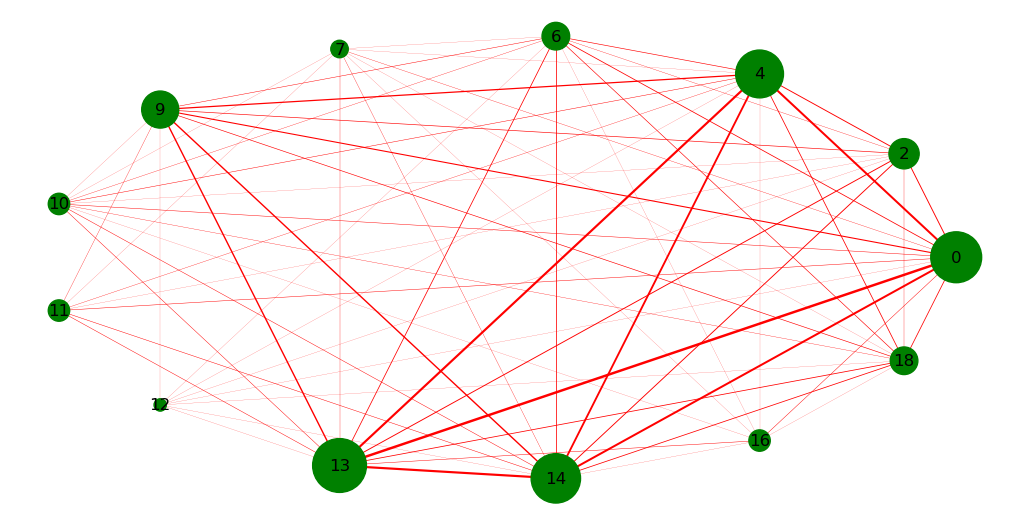

5
{0: 0.4892703862660944, 1: 0.002145922746781116, 2: 0.09871244635193133, 3: 0.002145922746781116, 4: 0.6330472103004292, 5: 0.004291845493562232, 6: 0.8218884120171673, 7: 0.0407725321888412, 8: 0.11802575107296137, 9: 0.7875536480686696, 10: 0.04935622317596566, 11: 0.5107296137339056, 12: 0.006437768240343348, 13: 0.2575107296137339, 14: 0.2167381974248927, 15: 0.0, 16: 0.4613733905579399, 17: 0.002145922746781116, 18: 0.0, 19: 0.0}
466


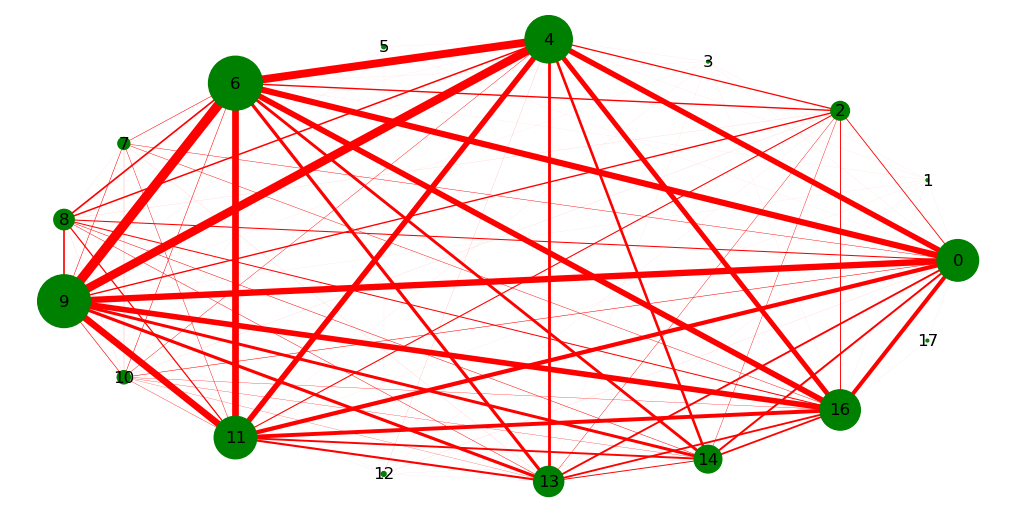

6
{0: 0.8118279569892473, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.9301075268817204, 7: 0.9086021505376344, 8: 0.0, 9: 0.8978494623655914, 10: 0.7311827956989247, 11: 0.6397849462365591, 12: 0.005376344086021506, 13: 0.0, 14: 0.005376344086021506, 15: 0.0, 16: 0.6451612903225806, 17: 0.0, 18: 0.0, 19: 0.0}
186


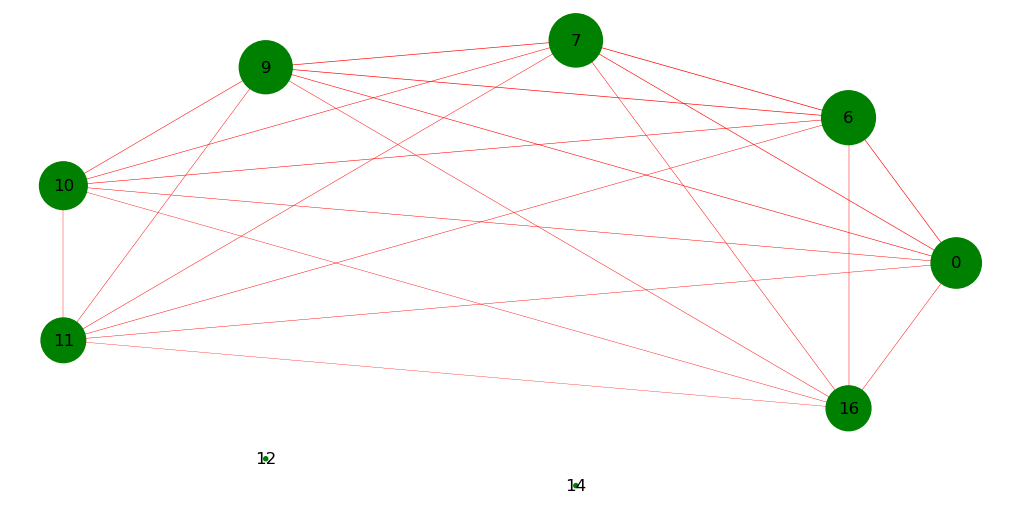

7
{0: 0.4186046511627907, 1: 0.47871873628784556, 2: 0.515577007459412, 3: 0.5783238262395788, 4: 0.06230802983764809, 5: 0.17068889863975428, 6: 0.03290917068889864, 7: 0.6441421676173761, 8: 0.571741992101799, 9: 0.5818341377797279, 10: 0.007459412022817025, 11: 0.051777095217200524, 12: 0.4216761737604212, 13: 0.009653356735410267, 14: 0.11715664765247916, 15: 0.06537955243527863, 16: 0.035980693286529176, 17: 0.0008775778850372971, 18: 0.007020623080298377, 19: 0.05835892935498026}
2279


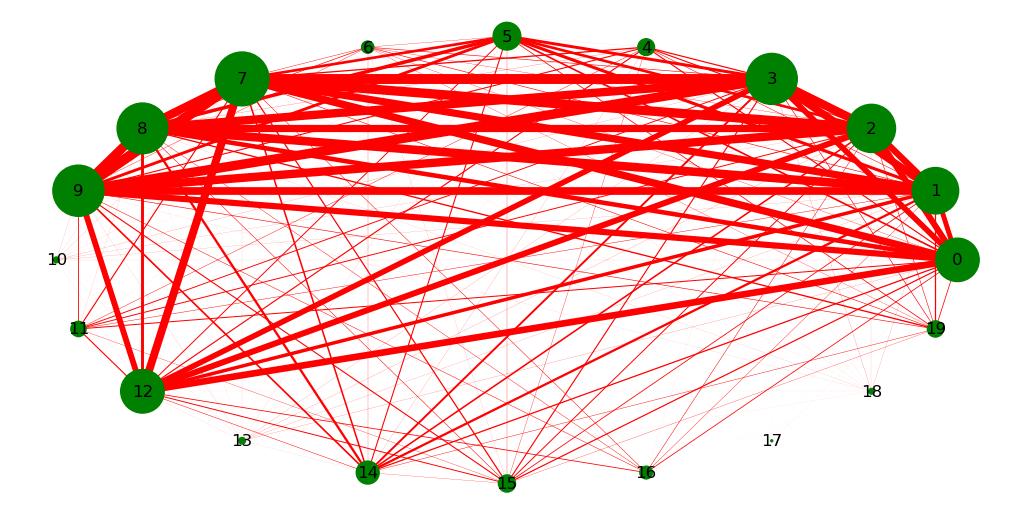

8
{0: 0.8733031674208145, 1: 0.06334841628959276, 2: 0.12669683257918551, 3: 0.07692307692307693, 4: 0.8733031674208145, 5: 0.7647058823529411, 6: 0.4072398190045249, 7: 0.004524886877828055, 8: 0.00904977375565611, 9: 0.08144796380090498, 10: 0.4479638009049774, 11: 0.5972850678733032, 12: 0.12217194570135746, 13: 0.058823529411764705, 14: 0.03619909502262444, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.5610859728506787, 19: 0.00904977375565611}
221


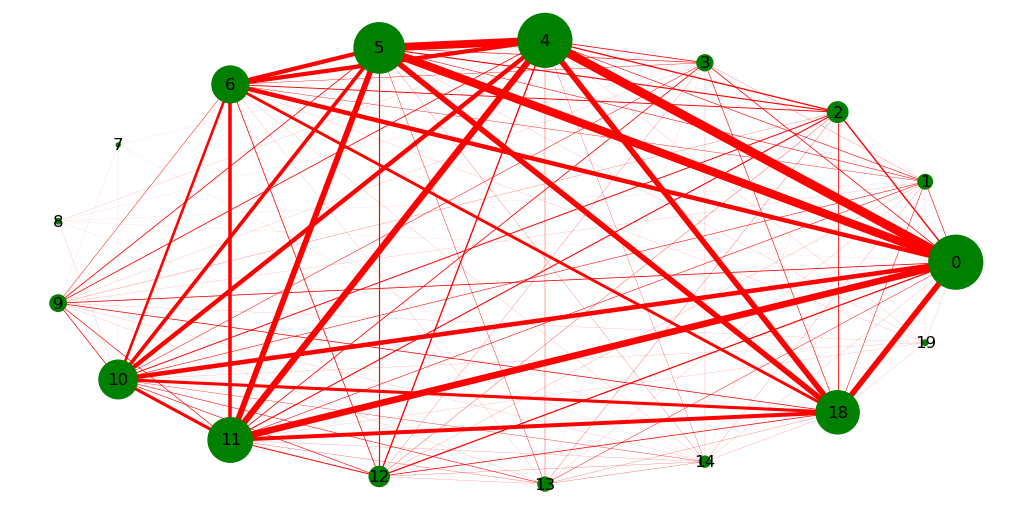

9
{0: 0.21739130434782608, 1: 0.0, 2: 0.782608695652174, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.8260869565217391, 15: 0.0, 16: 0.0, 17: 0.8260869565217391, 18: 0.0, 19: 0.0}
23


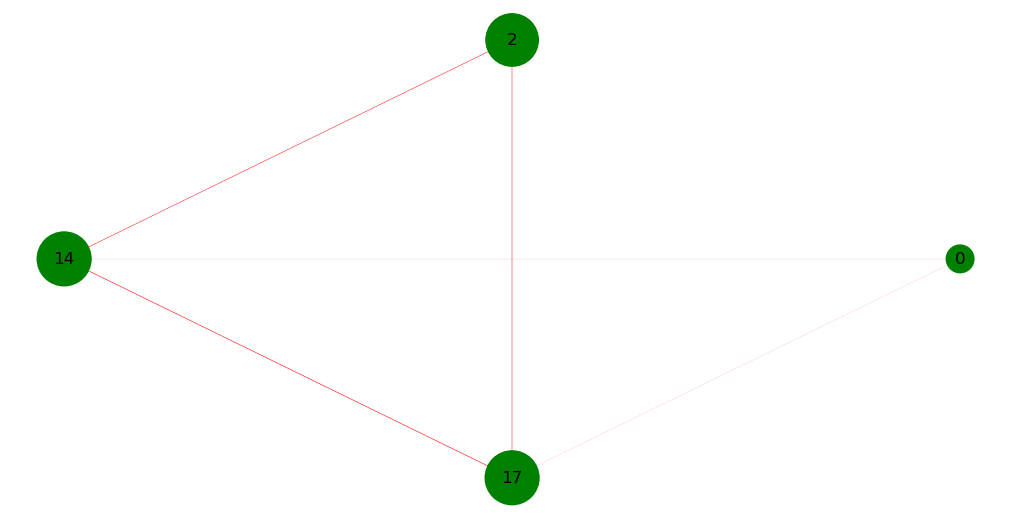

10
{0: 0.7317073170731707, 1: 0.16056910569105692, 2: 0.44715447154471544, 3: 0.022357723577235773, 4: 0.17682926829268292, 5: 0.0508130081300813, 6: 0.03048780487804878, 7: 0.052845528455284556, 8: 0.0, 9: 0.028455284552845527, 10: 0.24390243902439024, 11: 0.04878048780487805, 12: 0.05894308943089431, 13: 0.8292682926829268, 14: 0.49796747967479676, 15: 0.0, 16: 0.03048780487804878, 17: 0.07317073170731707, 18: 0.2784552845528455, 19: 0.0}
492


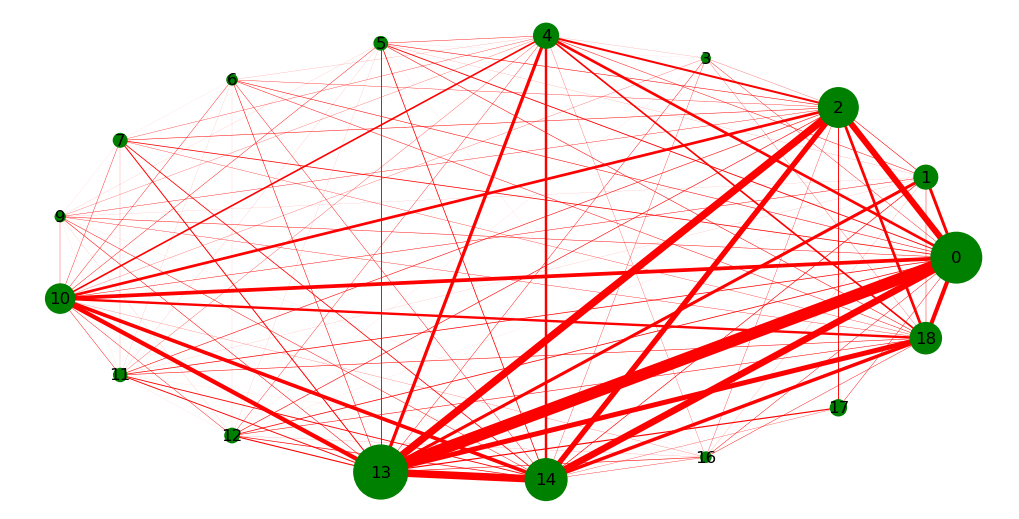

11
{0: 0.21016166281755197, 1: 0.5150115473441108, 2: 0.5381062355658198, 3: 0.5311778290993071, 4: 0.6836027713625866, 5: 0.5658198614318707, 6: 0.7159353348729792, 7: 0.14780600461893764, 8: 0.13394919168591224, 9: 0.15242494226327943, 10: 0.6327944572748267, 11: 0.2840646651270208, 12: 0.05542725173210162, 13: 0.057736720554272515, 14: 0.04157043879907621, 15: 0.10392609699769054, 16: 0.009237875288683603, 17: 0.0, 18: 0.11778290993071594, 19: 0.0023094688221709007}
433


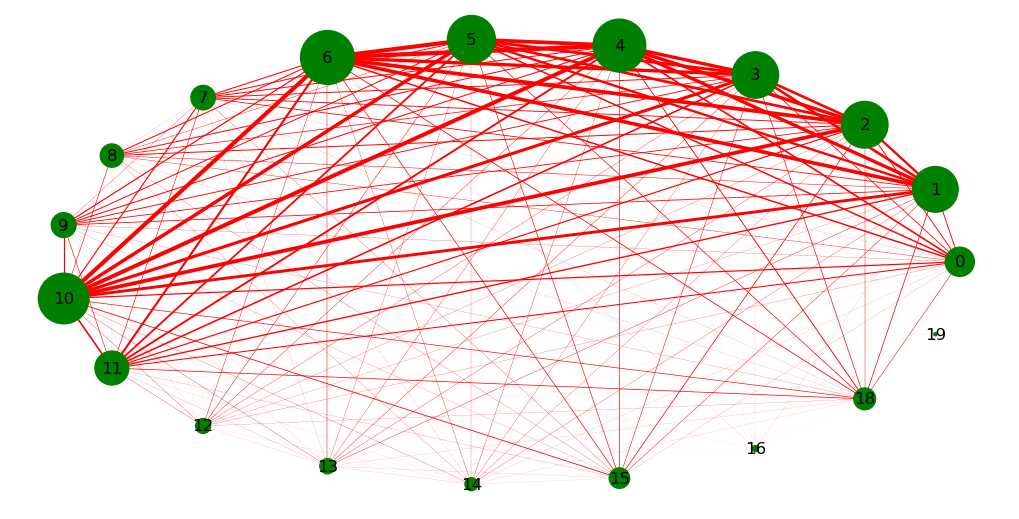

12
{0: 0.0392156862745098, 1: 0.23529411764705882, 2: 0.27450980392156865, 3: 0.0392156862745098, 4: 0.6862745098039216, 5: 0.21568627450980393, 6: 0.058823529411764705, 7: 0.0196078431372549, 8: 0.803921568627451, 9: 0.0196078431372549, 10: 0.058823529411764705, 11: 0.0784313725490196, 12: 0.6274509803921569, 13: 0.0, 14: 0.0, 15: 0.2549019607843137, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0}
51


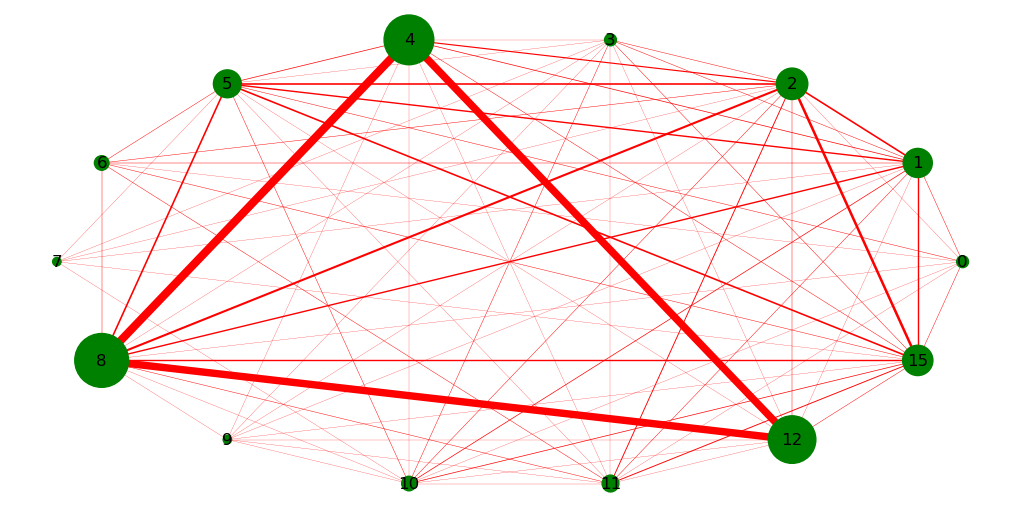

13
{0: 0.1331521739130435, 1: 0.5, 2: 0.03260869565217391, 3: 0.7119565217391305, 4: 0.75, 5: 0.04619565217391304, 6: 0.5516304347826086, 7: 0.043478260869565216, 8: 0.05434782608695652, 9: 0.08152173913043478, 10: 0.07065217391304347, 11: 0.06793478260869565, 12: 0.07608695652173914, 13: 0.20923913043478262, 14: 0.3858695652173913, 15: 0.0, 16: 0.14130434782608695, 17: 0.01358695652173913, 18: 0.453804347826087, 19: 0.0}
368


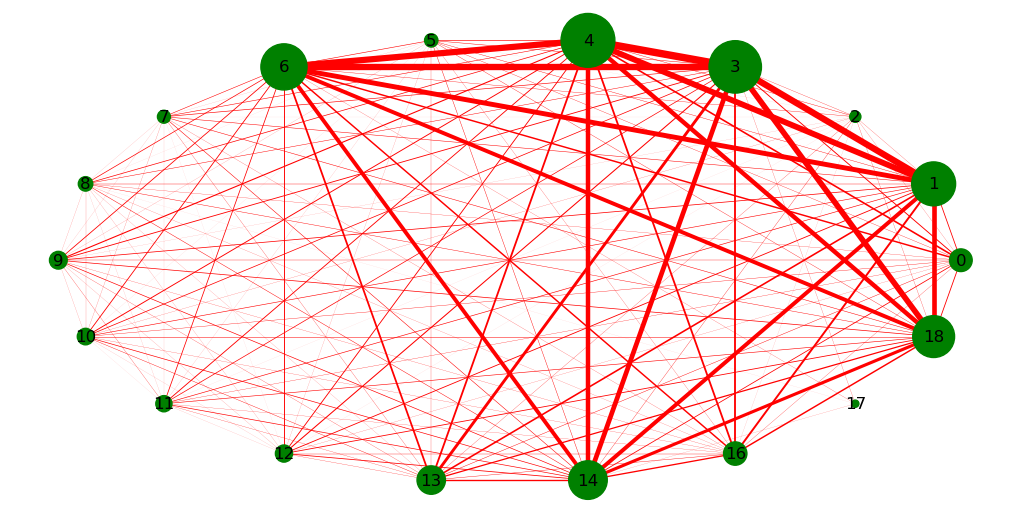

14
{0: 0.11553784860557768, 1: 0.6175298804780877, 2: 0.47410358565737054, 3: 0.1593625498007968, 4: 0.13545816733067728, 5: 0.41434262948207173, 6: 0.01593625498007968, 7: 0.07569721115537849, 8: 0.450199203187251, 9: 0.07171314741035857, 10: 0.06772908366533864, 11: 0.13147410358565736, 12: 0.06374501992031872, 13: 0.01195219123505976, 14: 0.02390438247011952, 15: 0.0398406374501992, 16: 0.00796812749003984, 17: 0.00398406374501992, 18: 0.0199203187250996, 19: 0.00398406374501992}
251


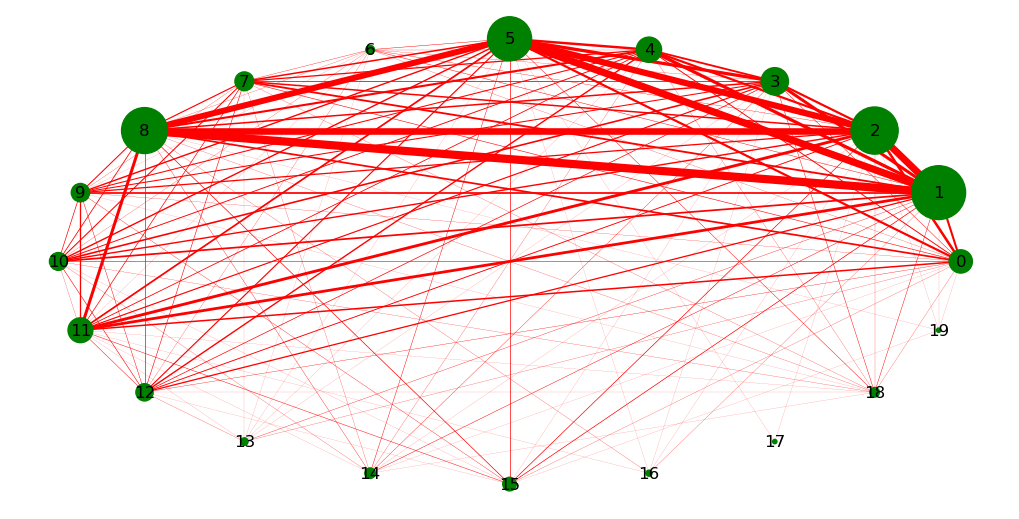

15
{0: 0.03568242640499554, 1: 0.5798394290811775, 2: 0.3702051739518287, 3: 0.06244424620874219, 4: 0.4023193577163247, 5: 0.5744870651204282, 6: 0.03479036574487065, 7: 0.12756467439785907, 8: 0.3389830508474576, 9: 0.04192685102586976, 10: 0.6030330062444246, 11: 0.7448706512042819, 12: 0.15075825156110614, 13: 0.08742194469223907, 14: 0.07850133809099019, 15: 0.08742194469223907, 16: 0.010704727921498661, 17: 0.29170383586083853, 18: 0.0026761819803746653, 19: 0.1008028545941124}
1121


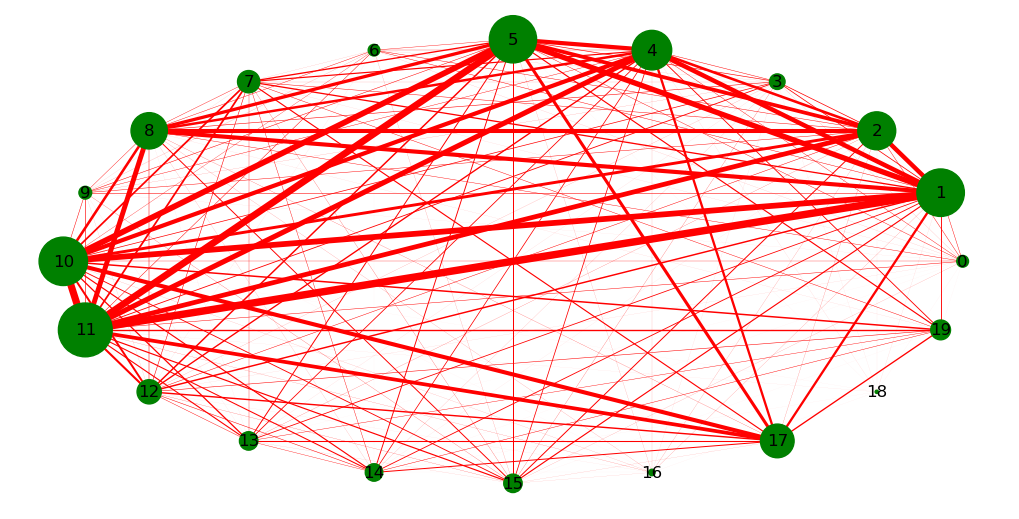

16
{0: 0.3532219570405728, 1: 0.5847255369928401, 2: 0.6587112171837709, 3: 0.162291169451074, 4: 0.7828162291169452, 5: 0.05489260143198091, 6: 0.7828162291169452, 7: 0.7040572792362768, 8: 0.14558472553699284, 9: 0.007159904534606206, 10: 0.07398568019093078, 11: 0.031026252983293555, 12: 0.13842482100238662, 13: 0.00477326968973747, 14: 0.08591885441527446, 15: 0.7613365155131265, 16: 0.0, 17: 0.0, 18: 0.002386634844868735, 19: 0.0}
419


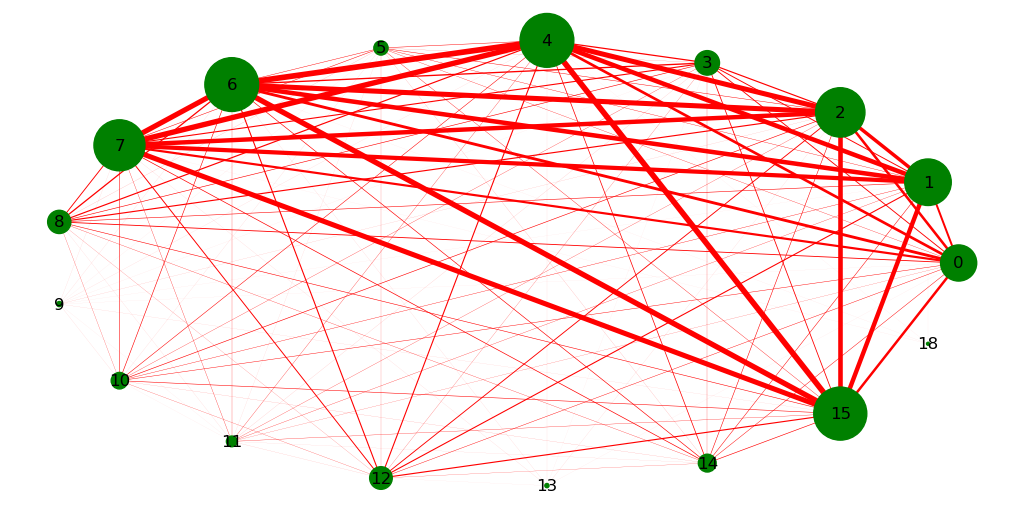

17
{0: 0.18518518518518517, 1: 0.14814814814814814, 2: 0.1111111111111111, 3: 0.6111111111111112, 4: 0.25925925925925924, 5: 0.018518518518518517, 6: 0.7592592592592593, 7: 0.37037037037037035, 8: 0.16666666666666666, 9: 0.037037037037037035, 10: 0.05555555555555555, 11: 0.018518518518518517, 12: 0.07407407407407407, 13: 0.037037037037037035, 14: 0.18518518518518517, 15: 0.0, 16: 0.0, 17: 0.2777777777777778, 18: 0.018518518518518517, 19: 0.0}
54


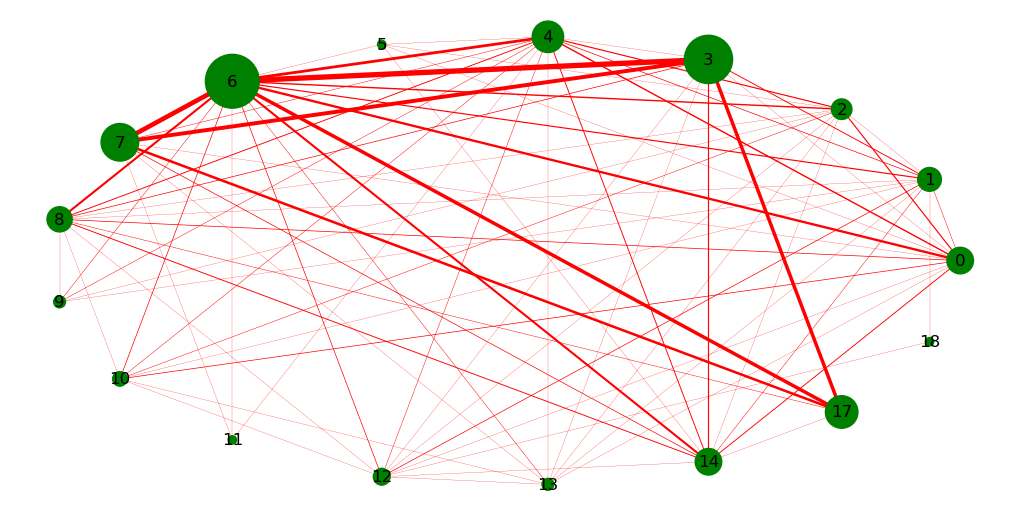

In [294]:
data = data.astype(float)
clusters = [data[k.labels_ == i] for i in range(n_clusters)]
# clusters = old_clusters
for see_cluster in range(n_clusters):
    print(see_cluster)
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
    
    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_circular(G, node_size=node_size, with_labels=True, edgelist=edges, width=weights, **options)
    plt.show()
